# Testing Mixture Density Network output layers (aka MDNs) and MDNs with LSTM head (aka Memory in World Models)

This notebook was used for testing and (visually) analyzing network fits with multi-kernel (aka Mixture Density Network, aka MDN) against single kernel output layer(s), and to furthermore combine an LSTM-RNN with a multi-kernel-MDN layer into a working version of the Memory module as it could be used for the World Models reimplementation.

Thus, the contents of this notebook can be divided into two parts:
1. MDN testing
- Data generation (sample from inverse sine wave with multimodal mappings)
- Model definition (subclass tf.keras.Model with custom kernel number mdn output layer)
- Training (using the tf/keras functional API)
- Visualization (compare fit of samples from predictions of single vs. multi-kernel model instances, visualize kernel parameter values underlying the predictions)

2. Memory 
- Model definition (combine LSTM head with mdn output layer into single Memory model)
- Data generation (add time dimension to data to enable use of RNNs) and Training (using a custom training loop)
- Visualization (plot train loss and samples from predictions)

<br>

Examples, code snippets and inspiration taken from  [Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/), [Mixture Density Networks with Edward, Keras and TensorFlow](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html), and [MDN layer implementation by cpmpercussion](https://github.com/cpmpercussion/keras-mdn-layer.git).

## Prerequisites
First, we need to make sure all requirements for running this notebook are fulfilled and define all neccessary imports.

In [1]:
# install mdn layer implementation
!pip install keras-mdn-layer

  Created wheel for keras-mdn-layer: filename=keras_mdn_layer-0.3.0-cp37-none-any.whl size=7054 sha256=7c72a99e63eec8e0d21ade036ac8a05e99690558c88842df9e457353a5e3b0f6
  Stored in directory: /root/.cache/pip/wheels/b6/e3/ba/8fb07898b8c8e5d4c1a035add0b71629b2fbe82ee8a5f0a2c8
Successfully built keras-mdn-layer


In [2]:
# imports to run the notebook
%matplotlib notebook
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from plotly import __version__

# enable display of plots for notebook execution via colab
# solution from: https://stackoverflow.com/questions/52859983/interactive-matplotlib-figures-in-google-colab/55435199#55435199
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
cf.go_offline()

init_notebook_mode(connected=False)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

# import the usual ML/ANN toolsets
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions
from sklearn.model_selection import train_test_split
import mdn # imports the MDN layer 
import random

# apply config function defined above
configure_plotly_browser_state()

## 1. MDN testing
### Data generation
First, we build a toy dataset resembling one-to-many x-to-y value mappings. The idea behind the task is to predict the value of an inverse sine function. The inverse sine wave function has multiple real-valued solutions at each point, so the Neural Network(NN) model needs to have the capacity to handle this in its loss function. An MDN is a good way to handle the predictions of these multiple output values.

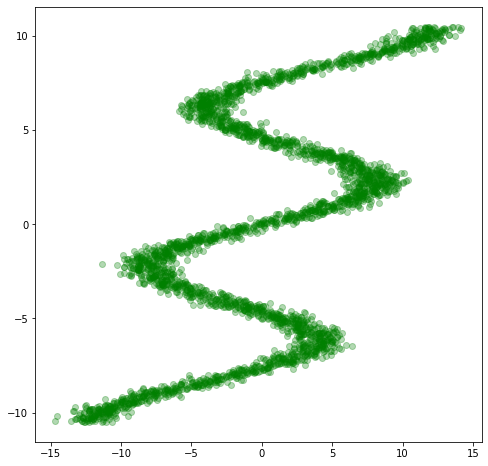

In [4]:
N_SAMPLES = 3000

y_data = np.float32(np.random.uniform(-10.5, 10.5, N_SAMPLES))
r_data = np.random.normal(size=N_SAMPLES)
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
x_data = x_data.reshape((N_SAMPLES, 1))

plt.figure(figsize=(8,8))
plt.plot(x_data, y_data, 'go',alpha=0.3)
plt.show()

### Model definition
Define NN model to fit the data.
Single MLP class can be used to produce single or multi-kernel output layer models, where MDNs are just a generalization for the output layer.


In [18]:
class MLP(tf.keras.Model):

    def __init__(self, num_mixtures=1, output_dim=1, *hidden_units):
        super(MLP, self).__init__(name="MLP")
        self.num_mixtures = num_mixtures
        self.output_dim = output_dim
        
        if hidden_units is None:
          self.hidden_layers = []
        else:
          self.hidden_layers = [tf.keras.layers.Dense(n_units, activation='relu') for n_units in hidden_units]
        
        self.out = mdn.MDN(self.output_dim, self.num_mixtures)

    @tf.function    
    def call(self, x):
        for l in self.hidden_layers:
          x = l(x)
        output = self.out(x)
        return output

Now we can initialize a Model with custom number of neurons in the hidden layer(s) (list argument hidden_neurons) and custom number of (gaussian) mixtures (mixtures) for which we want to generate parameters in the output layer to fit our data (of custom dimensionality output_dim).

In [19]:
N_MIXES = 10 # number of gaussian kernel functions in the mixture model
N_OUTPUTS = 1 # dimension of target data
hidden_units = [15,15] # number of neurons in hidden (dense) layer(s)

# initialize the models
simple_mlp = MLP(1, N_OUTPUTS, *hidden_units)
mlp_mdn = MLP(N_MIXES, N_OUTPUTS, *hidden_units)

# optimizer and loss function used for training an MLP model with N_MIXES kernels for N_OUTPUTS-D target data:
# optimizer = tf.keras.optimizers.Adam()
# loss = mdn.get_mixture_loss_func(N_OUTPUTS,N_MIXES)

### Training
Now we can instantiate two models - a simple_mlp (single gaussian kernel) and a mlp_mdn model with N_MIXES-kernels - and compile and train them using the tf.keras functional API and fit each of them to our generated data (to produce N_OUTPUTS-dimensional predictions for N_OUTPUTS-dimensional targets). 

We can afterwards inspect the model summaries for each model to compare the number of parameters (which should differ only for the mdn output layer, as the number of parameters gets scaled (increases) by the factor N_MIXES.

In [20]:
# compile and fit models with respective optimizer and loss function to inspect the summaries
simple_mlp.compile(loss=mdn.get_mixture_loss_func(N_OUTPUTS,1), optimizer=tf.keras.optimizers.Adam()) #, metrics=[mdn.get_mixture_mse_accuracy(N_OUTPUTS,1)])
history_simple_mlp = simple_mlp.fit(x=x_data, y=y_data, batch_size=128, epochs=250, validation_split=0.15, shuffle=True)
simple_mlp.summary()

Epoch 1/250
20/20 [==============================] - 2s 20ms/step - loss: 71.7302 - val_loss: 19.4042
Epoch 2/250
20/20 [==============================] - 0s 4ms/step - loss: 17.1015 - val_loss: 9.6622
Epoch 3/250
20/20 [==============================] - 0s 5ms/step - loss: 9.6415 - val_loss: 7.1517
Epoch 4/250
20/20 [==============================] - 0s 4ms/step - loss: 7.3015 - val_loss: 5.3408
Epoch 5/250
20/20 [==============================] - 0s 4ms/step - loss: 5.4082 - val_loss: 4.3661
Epoch 6/250
20/20 [==============================] - 0s 4ms/step - loss: 4.6259 - val_loss: 3.9860
Epoch 7/250
20/20 [==============================] - 0s 5ms/step - loss: 4.1518 - val_loss: 3.8093
Epoch 8/250
20/20 [==============================] - 0s 5ms/step - loss: 3.9576 - val_loss: 3.6790
Epoch 9/250
20/20 [==============================] - 0s 4ms/step - loss: 3.8484 - val_loss: 3.5274
Epoch 10/250
20/20 [==============================] - 0s 5ms/step - loss: 3.5979 - val_loss: 3.4367
Epoch

In [22]:
mlp_mdn.compile(loss=mdn.get_mixture_loss_func(N_OUTPUTS,N_MIXES), optimizer=tf.keras.optimizers.Adam()) #, metrics=[mdn.get_mixture_mse_accuracy(N_OUTPUTS,N_MIXES)])
history_mlp_mdn = mlp_mdn.fit(x=x_data, y=y_data, batch_size=128, epochs=250, validation_split=0.15, shuffle=True)
mlp_mdn.summary()

Epoch 1/250
20/20 [==============================] - 9s 98ms/step - loss: 8.2196 - val_loss: 6.2640
Epoch 2/250
20/20 [==============================] - 0s 6ms/step - loss: 6.5567 - val_loss: 5.1836
Epoch 3/250
20/20 [==============================] - 0s 6ms/step - loss: 5.4205 - val_loss: 4.4843
Epoch 4/250
20/20 [==============================] - 0s 7ms/step - loss: 4.6740 - val_loss: 4.0208
Epoch 5/250
20/20 [==============================] - 0s 7ms/step - loss: 4.1572 - val_loss: 3.6924
Epoch 6/250
20/20 [==============================] - 0s 6ms/step - loss: 3.8666 - val_loss: 3.4664
Epoch 7/250
20/20 [==============================] - 0s 7ms/step - loss: 3.5359 - val_loss: 3.3273
Epoch 8/250
20/20 [==============================] - 0s 7ms/step - loss: 3.4057 - val_loss: 3.2623
Epoch 9/250
20/20 [==============================] - 0s 7ms/step - loss: 3.3544 - val_loss: 3.2118
Epoch 10/250
20/20 [==============================] - 0s 7ms/step - loss: 3.3168 - val_loss: 3.1770
Epoch 11

### Visualization
We furthermore visualize

####1)  the models' error during training 
and 

####2)  the resulting fit of samples drawn from each model's parameter predictions for the kernel function(s) to the data after training, 
as well as

####3)  the outputted parameters themselves (priors over kernel functions with kernel means and variances).

#### Model error during training

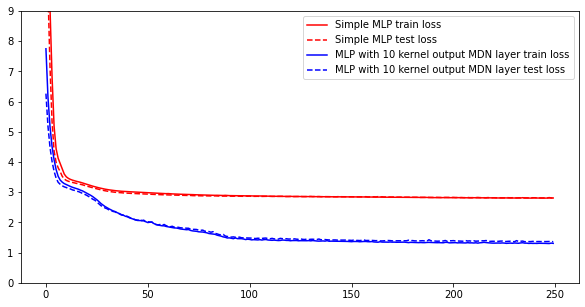

In [23]:
# plot the training and test loss
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history_simple_mlp.history['loss'], color='red',label="Simple MLP train loss")
plt.plot(history_simple_mlp.history['val_loss'], color='red',linestyle='dashed',label="Simple MLP test loss")
plt.plot(history_mlp_mdn.history['loss'],color='blue',label="MLP with 10 kernel output MDN layer train loss")
plt.plot(history_mlp_mdn.history['val_loss'],color='blue',linestyle='dashed', label="MLP with 10 kernel output MDN layer test loss")
plt.legend() #["Simple MLP train loss","Simple MLP test loss","MLP with 10 kernel output MDN layer train loss","MLP with 10 kernel output MDN layer test loss"])
plt.show()

#### Drawing samples from predicted parameters

We can use the sampling function provided with the mdn module to obtain predictions for original target datapoints from our model outputs (which are the parameters of gaussian distributions). The implemented procedure to get samples (n the mdn module) works as follows: 

First the parameters are split up into mus, sigmas and pis, then the categorical distribution formed by the pis is sampled to choose which mixture component should be sampled, then that component's mus and sigmas is used to sample from a multivariate normal model. This is implemented as follows:

In [ ]:
# sampling function of mdn layer class to get data point predictions from model outputs
# use as is if there is only one prediction to sample from
# otherwise use inside np.apply_along_axis()
def sample_from_output(params, output_dim, num_mixes, temp=1.0):
    """Sample from an MDN output with temperature adjustment."""
    mus = params[:num_mixes*output_dim]
    sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
    pis = softmax(params[-num_mixes:], t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m*output_dim:(m+1)*output_dim]
    sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
    cov_matrix = np.identity(output_dim) * sig_vector
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

We can use this function to sample data from predictions of our fitted models.

We firstly need to obtain predictions for parameters of the respective (gaussian) distributions for N_SAMPLES evenly spaced points on the x_axis from each trained model. 

Then we can sample datapoint predictions for targets from these parameters unsing the provided sampling function from above.

In [24]:
## Sample on some test data:
x_test_raw = np.float32(np.arange(-15,15,0.01))
N_TEST = x_test_raw.size
print("Testing:", N_TEST, "samples.")
x_test = x_test_raw.reshape(N_TEST,1) # needs to be a matrix, not a vector

# Obtain predictions from the model
y_test_simple = simple_mlp.predict(x_test)
y_test_mdn = mlp_mdn.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Sample from the predicted distributions
y_samples_simple = np.apply_along_axis(mdn.sample_from_output, 1, y_test_simple, 1, 1, temp=1.0)
y_samples_mdn = np.apply_along_axis(mdn.sample_from_output, 1, y_test_mdn, 1, N_MIXES, temp=1.0)

# Split up the mixture parameters (for future fun)
mus_simple = np.apply_along_axis((lambda a: a[:1]),1, y_test_simple)
sigs_simple = np.apply_along_axis((lambda a: a[1:2*1]),1, y_test_simple)
pis_simple = np.apply_along_axis((lambda a: mdn.softmax(a[2*1:])),1, y_test_simple)

mus_mdn = np.apply_along_axis((lambda a: a[:N_MIXES]),1, y_test_mdn)
sigs_mdn = np.apply_along_axis((lambda a: a[N_MIXES:2*N_MIXES]),1, y_test_mdn)
pis_mdn = np.apply_along_axis((lambda a: mdn.softmax(a[2*N_MIXES:])),1, y_test_mdn)

Testing: 3000 samples.


####Visualize the samples from model predictions
See how much better the samples from the multi-kernel MLP approximate the distribution of our target data samples!

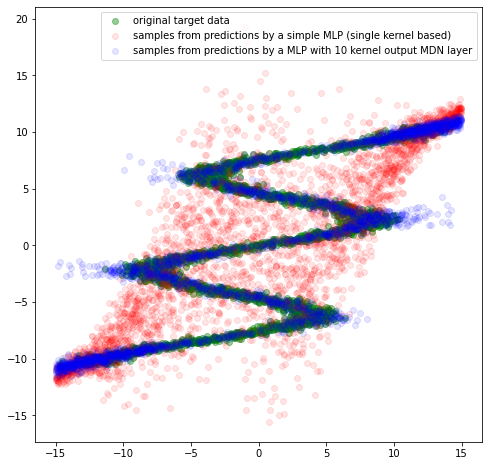

In [25]:
# plot the samples from model predictions against original target data
plt.figure(figsize=(8,8))
plt.scatter(x_data, y_data, color='green', alpha=0.4, label="original target data")
plt.scatter(x_test_raw, y_samples_simple, color='red', alpha=0.1, label="samples from predictions by a simple MLP (single kernel based)")
plt.scatter(x_test_raw, y_samples_mdn, color='blue', alpha=0.1, label="samples from predictions by a MLP with " + str(N_MIXES) + " kernel output MDN layer")
plt.legend()
plt.show()
# notice how much better a multi-kernel output layer can help in learning a model of the data

#### Visualize model outputs (mixture parameters)
We can also plot the parameters (those we used to draw samples previously) themselves to get insights into what the models have learned.

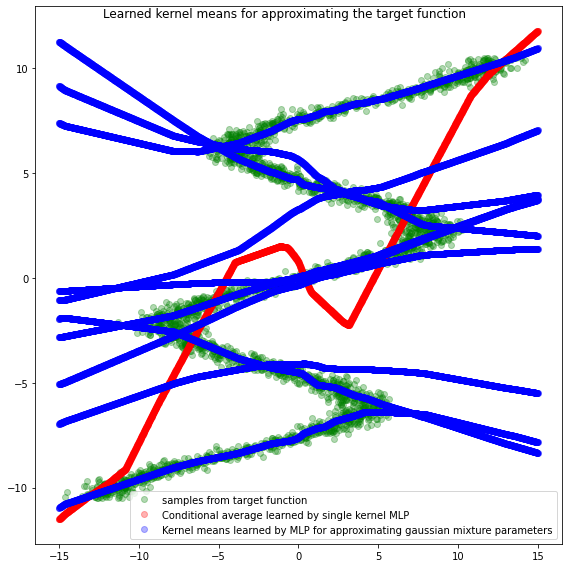

In [35]:
# Plot the learned kernel means to get insights into how the models learns to produce the mixture(s)/predictions.
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'go',alpha=0.3)
plt.plot(x_test,mus_simple,'ro',alpha=0.3)
plt.plot(x_test,mus_mdn,'bo',alpha=0.3)
plt.legend(["samples from target function","Conditional average learned by single kernel MLP","Kernel means learned by MLP for approximating gaussian mixture parameters"])
plt.suptitle("Learned kernel means for approximating the target function")
plt.tight_layout()
plt.show()
# see how the different kernels capture the different modi in the data

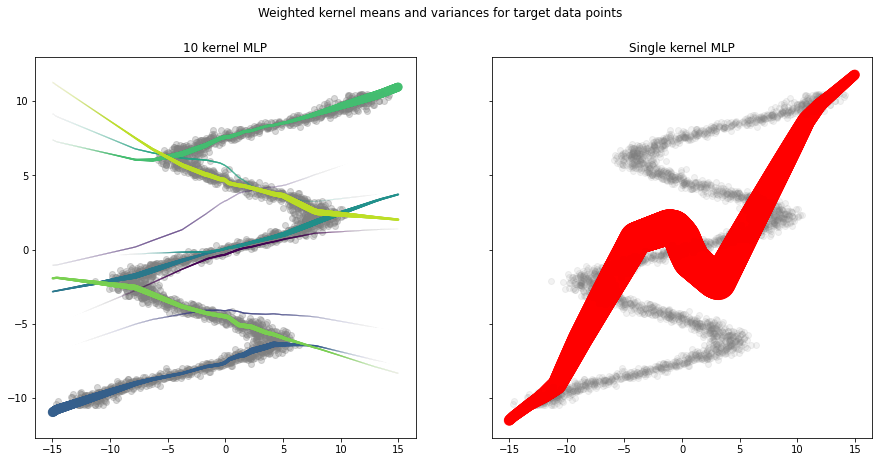

In [27]:
# Plot the variances and weightings (kernel priors) of the means as well.
colors = matplotlib.cm.viridis(np.linspace(0,1,N_MIXES+1))

fig,ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(15, 7))
ax[0].scatter(x_data,y_data,color="grey",alpha=0.3)

for kernel,color in zip(np.arange(N_MIXES),colors):
    ax[0].scatter(x_test, mus_mdn[:,kernel], marker='o', color=color, s=200*sigs_mdn[:,kernel]*pis_mdn[:,kernel],alpha=0.3)

ax[1].scatter(x_data,y_data,color="grey",alpha=0.1)
ax[1].scatter(x_test, mus_simple[:,], marker='o', color="red", s=200*sigs_simple[:,]*pis_simple[:,],alpha=0.3)

ax[0].set_title(label=str(N_MIXES)+" kernel MLP")
ax[1].set_title(label="Single kernel MLP")

fig.suptitle("Weighted kernel means and variances for target data points")
plt.show()

## 2. Memory: Adding the time dimension

### Memory Model definition
Next we define an Memory model class consisting of a LSTM-RNN with an additional MDN output layer.

The model can be used to produce predictions for future target data (from possibly multi-modal functions) based on the history of previously processed data.

In [4]:
import os

class Memory(tf.keras.Model):
  """ Memory class to model sequential data of arbitrary dimension using a Gaussian Mixture """
  def __init__(self, 
               input_dim=35,
               lstm_nodes=256, 
               output_dim=32, 
               num_mixtures=5, 
               num_timesteps=999,
               load_model=False,
               results_dir=None,
               hidden_units=None
               ):                        
    super(Memory, self).__init__(name="Memory")

    self.lstm_nodes = lstm_nodes
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.num_mixtures = num_mixtures
    
    #lstm_cell = tf.keras.layers.LSTMCell(lstm_nodes, kernel_initializer='glorot_uniform',recurrent_initializer='glorot_uniform',bias_initializer='zeros',name='lstm_cell')
    
    self.lstm = tf.keras.layers.LSTM(lstm_nodes,return_sequences=True,return_state=True,name='lstm_layer')
    
    if hidden_units is None:
      self.hidden_layers = []
    else:
      self.hidden_layers = [tf.keras.layers.Dense(n_units, activation='relu') for n_units in hidden_units]

    self.mdn_out = tf.keras.layers.TimeDistributed(mdn.MDN(output_dim,num_mixtures,name='mdn_outputs'),name='td_mdn')

    self.components = {
        'lstm': self.lstm,
        'hidden_layers': self.hidden_layers,
        'gaussian-mix': self.mdn_out
    }

    if load_model:
      self.load(results_dir)

  def save(self, filepath):
    """ save model weights """
    filepath = os.path.join(filepath, 'models')
    os.makedirs(filepath, exist_ok=True)
    print('saving model to {}'.format(filepath))
    for name, component in self.components.items():
        component.save_weights('{}/{}.h5'.format(filepath, name))

  def load(self, filepath):
    """ load model weights """
    filepath = os.path.join(filepath, 'models')
    print('loading model from {}'.format(filepath))

    for name, component in self.components.items():
        component.load_weights('{}/{}.h5'.format(filepath, name))
        self.components[name] = component

  @tf.function
  def get_zero_hidden_state(self, inputs):
    return [tf.zeros((inputs.shape[0], self.lstm_nodes)),
            tf.zeros((inputs.shape[0], self.lstm_nodes))]
  
  @tf.function
  def get_initial_state(self, inputs):
    return self.initial_state

  def get_y_pred(self, mix_params, temperature=1.0):
    # use sampling function provided by the mdn module to generate predictions
    y_samples = np.apply_along_axis(mdn.sample_from_output, 2, mix_params, self.output_dim, self.num_mixtures, temp=temperature)
    return y_samples

  # only eager execution possible currently
  #@tf.function
  def call(self, inputs, state):
    # inputs shape=(batch_size,num_timesteps=1,input_dim)
    # single timestep processing per call with input
    inputs = tf.reshape(inputs, (inputs.shape[0], 1, self.input_dim))
    
    self.initial_state = state
    self.lstm.get_initial_state = self.get_initial_state
    lstm_out, h_state, c_state = self.lstm(inputs)
    # pass lstm_output through additional dense layers for further processing if hidden_units were specified)
    if self.hidden_layers is not None:
      for l in self.hidden_layers:
        lstm_out = l(lstm_out)
    mix_params = self.mdn_out(lstm_out)
    return mix_params, h_state, c_state

### Data generation and Training

In [5]:
# train model on a single batch of input data, predict parameters for single timestep with given model state
def train_step(model, input, target, state, loss_function, optimizer):
    with tf.GradientTape() as tape:
      mix_params, _, _ = model(input, state)
      loss = loss_function(target, mix_params)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [15]:
# data (hyper)parameters
N_SAMPLES = 2500
num_timesteps = 1
num_features = 1       # output dimension

# training (hyper)parameters
epochs = 5000          # originally 5000
batch_size = N_SAMPLES
batch_per_epoch = tf.math.ceil(N_SAMPLES/batch_size)
initial_lr = 0.001
decay_steps = epochs * batch_per_epoch
end_lr = 0.00001
grad_clip_value = 1.0

# model (hyper)parameters
num_mixtures = 24
hidden_units = None   # additional intermediate dense layer(s') units
lstm_nodes = 64

y = np.random.uniform(-10.5, 10.5, (1, N_SAMPLES)).T
r = np.random.normal(size=(N_SAMPLES, 1))
x = np.sin(0.75*y)*7.0+y*0.5+r*1.0
y_data = y.reshape(N_SAMPLES, num_timesteps, num_features).astype(np.float32)
x_data = x.reshape(N_SAMPLES, num_timesteps, num_features).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(1).batch(batch_size)

learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=initial_lr,
                                                                  decay_steps=decay_steps,
                                                                  end_learning_rate=end_lr)
optimizer = tf.keras.optimizers.Adam(learning_rate, clipvalue=grad_clip_value)
loss_function = mdn.get_mixture_loss_func(y_data.shape[-1],num_mixtures)

memory = Memory(
    input_dim=num_features, 
    output_dim=num_features, 
    num_timesteps=num_timesteps, 
    lstm_nodes=lstm_nodes,
    hidden_units=hidden_units,
    num_mixtures=num_mixtures,
    )

# loss accumulator
loss = np.zeros(epochs)

for epoch in range(epochs):
    batch_losses = []
    # iteratively train on batches
    for batch in dataset:
        # initialize RNN with zero state for each new batch
        state = memory.get_zero_hidden_state(batch[0])
        batch_loss = train_step(memory, *batch, state, loss_function, optimizer)
        batch_losses.append(batch_loss)

    loss[epoch] = np.mean(batch_losses)
    # print previous batch loss every 100 epochs
    if epoch % 100 == 1:
        print(epoch, loss[epoch])

1 14.205951690673828
101 5.654263973236084
201 3.815300703048706
301 3.3847968578338623
401 3.1134865283966064
501 2.882570266723633
601 2.599910259246826
701 2.342052459716797
801 2.2164247035980225
901 2.1085188388824463
1001 1.9699105024337769
1101 1.855286955833435
1201 1.7669259309768677
1301 1.675985336303711
1401 1.6264230012893677
1501 1.5966745615005493
1601 1.574923038482666
1701 1.5596004724502563
1801 1.5414413213729858
1901 1.5242513418197632
2001 1.5102529525756836
2101 1.4946367740631104
2201 1.4804880619049072
2301 1.466946005821228
2401 1.4549915790557861
2501 1.444244384765625
2601 1.4342914819717407
2701 1.425046443939209
2801 1.4167126417160034
2901 1.4130645990371704
3001 1.407166838645935
3101 1.401752233505249
3201 1.3954797983169556
3301 1.389767050743103
3401 1.3847453594207764
3501 1.3799920082092285
3601 1.3755954504013062
3701 1.3715695142745972
3801 1.3675940036773682
3901 1.3639872074127197
4001 1.360598087310791
4101 1.3574411869049072
4201 1.354518651962

### Visualization

#### Model error during training

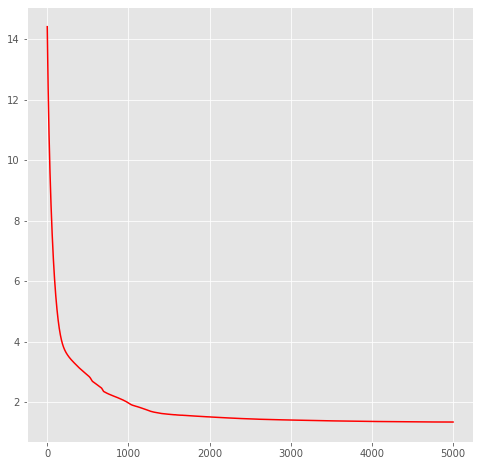

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), loss[:epochs], 'r-')
# plt.style.use('ggplot') # uncomment for minimalistic style
plt.show()

#### Samples from model predictions

In [27]:
# generate prediction "anchors" for testing
x_test = np.float32(np.arange(-15, 15, 0.1))
n_test = x_test.shape[0]
x_test = x_test.reshape(n_test, 1, 1)
# generate predictions and samples from them
mus, sigs, pis, y_pred = np.zeros(n_test),np.zeros(n_test),np.zeros(n_test),np.zeros(n_test)

for i, x in enumerate(x_test):
    state = memory.get_zero_hidden_state(x)
    pred, _, _ = memory(x, state)
    pred = np.squeeze(pred)
    # store samples from parameters
    y_pred[i] = mdn.sample_from_output(pred, num_features, num_mixtures, temp=1.0)#.reshape((1,)) #memory.get_y_pred(pred)

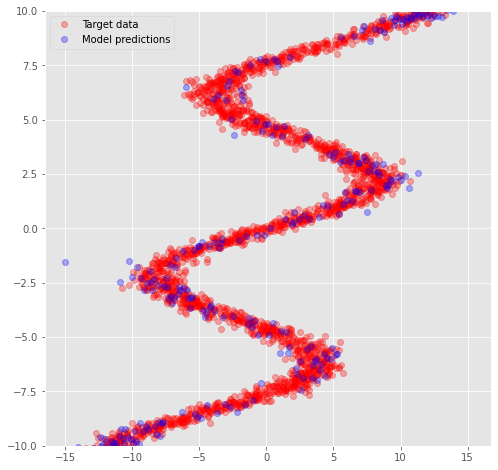

In [29]:
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(y_pred), 'bo', alpha=0.3)
plt.ylim(-10, 10)
plt.legend(['Target data','Model predictions'])
plt.show()

#### Test saving and loading functions

In [31]:
# try to save & load model weights
memory.save_weights('./mdl')
memory_reloaded = Memory(
    input_dim=1, 
    output_dim=num_features, 
    num_timesteps=num_timesteps, 
    lstm_nodes=lstm_nodes, 
    num_mixtures=num_mixtures
)
memory_reloaded.load_weights('./mdl')

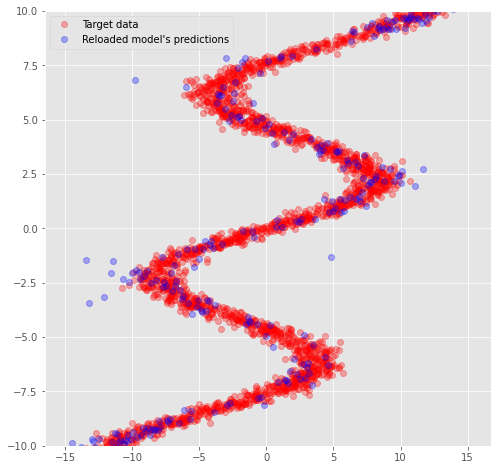

In [32]:
# generate predictions from reloaded model for testing
x_test = np.float32(np.arange(-15, 15, 0.1))
n_test = x_test.shape[0]
x_test = x_test.reshape(n_test, 1, 1)
# generate predictions and samples from them
mus_r, sigs_r, pis_r, y_pred_r = np.zeros(n_test),np.zeros(n_test),np.zeros(n_test),np.zeros(n_test)

for i, x in enumerate(x_test):
    state = memory_reloaded.get_zero_hidden_state(x)
    pred, _, _ = memory_reloaded(x, state)
    pred = np.squeeze(pred)
    # store samples from parameters
    y_pred_r[i] = mdn.sample_from_output(pred, num_features, num_mixtures, temp=1.0)#.reshape((1,)) #memory.get_y_pred(pred)
    
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(y_pred_r), 'bo', alpha=0.3)
plt.ylim(-10, 10)
plt.legend(['Target data','Reloaded model\'s predictions'])
plt.show()

### Backup implementation / precursor versions for Memory model class and training

In [25]:
### BACKUP VERSION of Memory and precursor to MemoryV2 which a the refined version of this ###
import os

class MemoryV0(tf.keras.Model):
  """ Memory class to model sequential data of arbitrary dimension using a Gaussian Mixture """
  def __init__(self, 
               input_dim=35, 
               lstm_nodes=256, 
               output_dim=32, 
               num_mixtures=5, 
               num_timesteps=999,
               epochs=1, batch_per_epoch=1,
               initial_lr=0.001, end_lr=0.00001, 
               grad_clip=1.0, 
               load_model=False,
               results_dir=None):
    super(MemoryV0, self).__init__(name="MemoryV0")

    self.lstm_nodes = lstm_nodes
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.num_mixtures = num_mixtures
    
    self.loss_fn = mdn.get_mixture_loss_func(output_dim,num_mixtures)
    decay_steps = epochs * batch_per_epoch
    learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=initial_lr,
                                                                  decay_steps=decay_steps,
                                                                  end_learning_rate=end_lr)
    self.optimizer = tf.keras.optimizers.Adam(learning_rate, clipvalue=grad_clip)

    lstm_cell = tf.keras.layers.LSTMCell(lstm_nodes, kernel_initializer='glorot_uniform',recurrent_initializer='glorot_uniform',bias_initializer='zeros',name='lstm_cell')
    
    self.lstm = tf.keras.layers.RNN(lstm_cell,return_sequences=True,return_state=True,name='lstm_wrapper')
    
    self.mdn_out = tf.keras.layers.TimeDistributed(mdn.MDN(output_dim,num_mixtures,name='mdn_outputs'),name='td_mdn')

    self.components = {
        'lstm': self.lstm,
        'gaussian-mix': self.mdn_out
    }

    if load_model:
      self.load(results_dir)

  def save(self, filepath):
    """ save model weights """
    filepath = os.path.join(filepath, 'models')
    os.makedirs(filepath, exist_ok=True)
    print('saving model to {}'.format(filepath))
    for name, component in self.components.items():
        component.save_weights('{}/{}.h5'.format(filepath, name))

  def load(self, filepath):
    """ load model weights """
    filepath = os.path.join(filepath, 'models')
    print('loading model from {}'.format(filepath))

    for name, component in self.components.items():
        component.load_weights('{}/{}.h5'.format(filepath, name))
        self.components[name] = component

  def get_zero_hidden_state(self, inputs):
    return [tf.zeros((inputs.shape[0], self.lstm_nodes)),
            tf.zeros((inputs.shape[0], self.lstm_nodes))]
  
  def get_initial_state(self, inputs):
    return self.initial_state

  def get_y_pred(self, mix_params, temperature=1.0):
    # use sampling function provided by the mdn module to generate predictions
    y_samples = np.apply_along_axis(mdn.sample_from_output, 2, mix_params, self.output_dim, self.num_mixtures, temp=temperature)
    return y_samples

  def call(self, input, state, temperature=1.0):
    # input shape=(batch_size,num_timesteps,input_dim)
    input = tf.reshape(input, (1, 1, self.input_dim))
    assert input.shape[0] == 1
    temperature = np.array(temperature).reshape(1, 1)
    assert temperature.shape[0] == input.shape[0]

    # mixture, h_state, c_state = self.lstm(x, state)
    self.initial_state = state
    self.lstm.get_initial_state = self.get_initial_state
    lstm_out, h_state, c_state = self.lstm(inputs)
    #pi, mu, sigma = self.mdn_out(lstm_out) #, temperature
    mix_params = self.mdn_out(lstm_out)
    return mix_params, h_state, c_state

  def train_step(self, input, target, state):
    with tf.GradientTape() as tape:
      lstm_out, _, _ = self.lstm(input, state)
      # print(target.shape)
      pred = self.mdn_out(lstm_out)
      # print(pred)
      loss = self.loss_fn(target, pred)
      gradients = tape.gradient(loss, self.lstm.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.lstm.trainable_variables))
    return loss

In [ ]:
### BACKUP VERSION OF TRAIN LOOP TO USE WITH BACKUP MEMORY CLASS ###
N_SAMPLES = 2500
epochs = 5000
num_timesteps = 1
num_features = 1
num_mix = 24
batch_size = 1024

y = np.random.uniform(-10.5, 10.5, (1, N_SAMPLES)).T
r = np.random.normal(size=(N_SAMPLES, 1))
x = np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0
y_data = y.reshape(N_SAMPLES, num_timesteps, num_features).astype(np.float32)
x_data = x.reshape(N_SAMPLES, num_timesteps, num_features).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(1).batch(batch_size)

optimizer = tf.keras.optimizers.Adam()

memory = MemoryV0(
    input_dim=1, 
    output_dim=1, 
    num_timesteps=num_timesteps, 
    lstm_nodes=64, 
    num_mixtures=num_mix,
    initial_lr=0.001,
    end_lr=0.001,
    )

loss = np.zeros(epochs)

for epoch in range(epochs):
    batch_losses = []
    for batch in dataset:
        state = memory.get_zero_hidden_state(batch[0])
        #print("memory state shape",state)
        batch_loss = memory.train_step(*batch, state)
        batch_losses.append(batch_loss)

    loss[epoch] = np.mean(batch_losses)
        
    if epoch % 500 == 1:
        print(epoch, loss[epoch])